<a href="https://colab.research.google.com/github/onew11/study/blob/main/%EC%82%AC%EC%A7%84%ED%95%A9%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.패키지 및 모델 로드

In [1]:
##행렬 연산 패키지
import numpy as np
##이미지 처리(제어) 패키지
from PIL import Image	 
##그래프 패키지
import matplotlib.pyplot as plt
##그래프 패키지(2D를 그래프의 컨버스 영역에 표현)
import matplotlib.patches as mpatches
##딥러닝 프레임워크
import torch
##이미지 변환 기능
from torchvision import transforms, models
##이미지 처리 패키지
import cv2

# 2.컬러 팔레트 생성

In [3]:
##pre-trained model을 받아 온다.
##tourchvision에서 제공하는 Semantic Segmentation용 2개의 모델(FCN ResNet101, DeepLabV3 ResNet101) 중 조금 더 좋은 결과를 보여주는 deeplabv3_resnet101을 사용한다.
##pretrained를 true로 해야 미리 학습된 weight들을 이어서 가지고 온다.
##eval()을 활용하여 훈련 모드로 전환하고 모델에 저장한다.
model=models.segmentation.deeplabv3_resnet101(pretrained= True ).eval()

<ipython-input-4-af9eb7f90810>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()


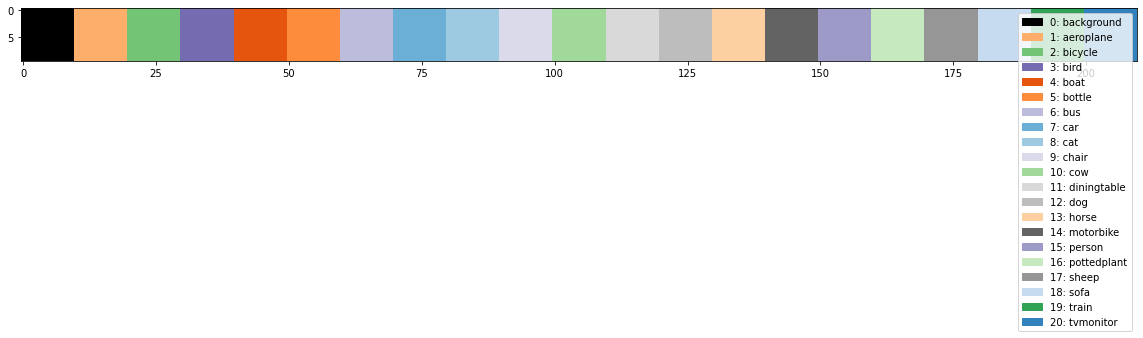

In [4]:
##COCO DataSet을 사용한다. --> 많은 그림 파일을 가지고 있으므로 용량이 크다.
##COCO DataSet은 21개의 레이블로 이루어져 있다.
##색깔로 구별하기 위해 팔레트를 만든다.
labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
##Matplot에는 여러개의 color를 섞은 colormap이 있다. 
##get_cmap으로 원하는 종류의 색깔만 가져온다.
cmap = plt.cm.get_cmap('tab20c')
##특정 수열(array)을 생선한 후 list형식으로 바꿔준다.
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
##시드(특정 시작 숫자) 설정한다.
np.random.seed(2020)
##colors 배열 순서를 변경한다.
np.random.shuffle(colors)
##배경색을 검은색으로 지정하여 추가한다.
colors.insert(0, [0, 0, 0])
##넘파이 배열의 데이터 타입을 uint8로 정의한다. uint8은 양수만 표현 가능하다.
colors = np.array(colors, dtype=np.uint8)
##empty : 메모리 할당만 받고 초기화 없이 반환한다.
##초기화 되지 않는 배열을 만들고 데이터 타입을 uint8로 정의한다.
palette_map = np.empty((10, 0, 3), dtype=np.uint8)
##범례 추가하기
legend = []
##0~20까지 for문을 돌면서 범례에 추가를 한다.
for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
##원소가 3인 10*10 배열을 생성하고 데이터 타입을 uint8로 정의한다
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
##배열을 위에서 아래로 연결한다.
##axis 0 : 좌->우, axis 1 : 위->아래
    palette_map = np.concatenate([palette_map, c], axis=1)
##그래프의 사이즈를 설정한다 (가로:20inch, 세로 2inch)
plt.figure(figsize=(20, 2))
##legend : 데이터의 종류를 표시하기 위한텍스트
##범례를 추가한다.
plt.legend(handles=legend)
##팔레트를 보여준다.
plt.imshow(palette_map)

# 3. Segment 함수

In [5]:
##segment라는 함수를 정의한다. 모델과 이미지를 input으로 받는다.
def segment(net, img):

##transforms : 이미지 전처리 모듈 
##preprocess라는 변수에 저장
    preprocess = transforms.Compose([

##이미지를 텐서 형태로 변환한다.
        transforms.ToTensor(),

##Normalize : 이미지 정규화
##모델에서 지정해준 mean값과 std(standard deviation) 를 정해주고 전처리를 한다.
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]		##std(standard deviation) : 표준편차
        ),
   ])

##이미지를 텐서로 만든다.
##이미지 텐서 이므로 (3,이미지 세로 크기, 이미지 가로 크기)의 텐서가 나온다.
    input_tensor = preprocess(img)



##모델에 넣을때는 배치 단위로 넣어야 하므로 (1, 3, 이미지 세로 크기, 이미지 가로크기)로 만들기 위해 unsqueeze를 사용한다.
##unsqueeze : 텐서에 차원(새로운 축)을 추가한다.
    input_batch = input_tensor.unsqueeze(0)

##GPU를 사용할 수 있는 경우 = cuda를 사용할 수 있다.
##cuda가 없는 경우 CPU에서 작동 되므로 느릴 수 있다.
    if torch.cuda.is_available():

##배치를  cuda로 바꿔준다. -> cuda로 이동 시킨다.
        input_batch = input_batch.to('cuda')

##모델도 cuda로 돌릴 수 있도록 설정한다.
        model.to('cuda')

##모델에 input_batch를 넣어주면 실행된다.
##레이블이 21개이므로 이미지 크기만큼 21개의 텐서가 출력된다.
##1: background 2: aeroplane .......20 : tvmonitor
    output = model(input_batch)['out'][0] 

##argmax : 각 픽셀의 채널 방향으로 최소값의 채널 인덱스로 반환한다.
##파이토치의 경우는 채널 방향이 첫번째에 있기때문에 0번 axis에서 argmax를 하게 되면 이미지의 높이랑 가로 크기만큼의 텐서만 남게된다. 이를 넘파이 형태로 바꿔준다.
    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 



##image.fromarray() :numpy ndarray를 pillow image 타입으로 변환한다.
##output으로 나온 predictions을 pillow 이미지로 바꿔주고 이미지 크기로 다시 resize해준다.
    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))

##팔레트를 적용한다.
    r.putpalette(colors)

##Semantic Segmentation해서 팔레트를 적용한 결과와 out_predictions를 return 값으로 반환한다.
    return r, output_predictions

# 4. Segment_map 이미지 결과

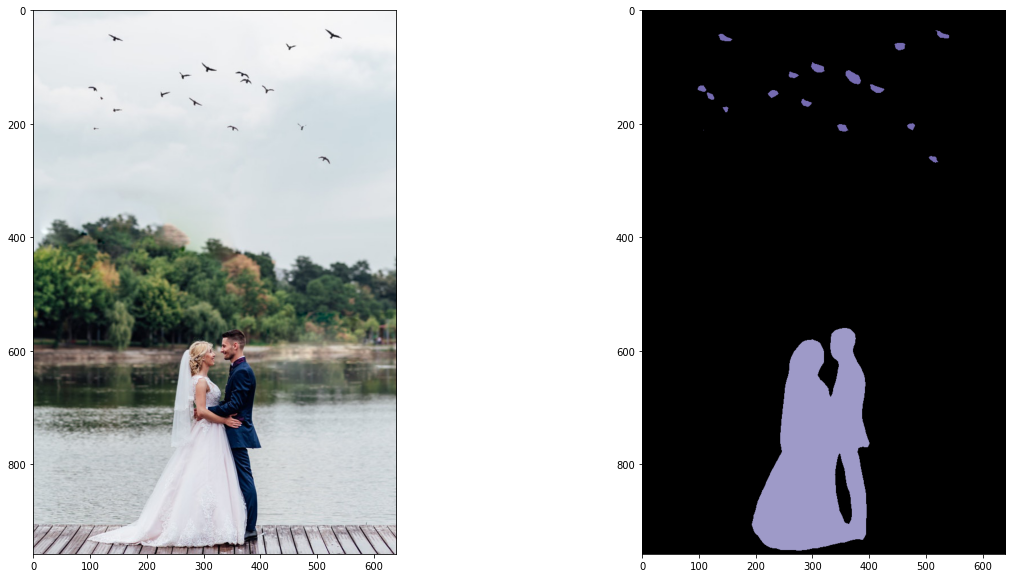

In [7]:
##이미지를 로드한다.(rgb이미지가 로드 된다.)
##넘파이 배열로 바꿔준 후 img 변수에 저장한다.
img = np.array(Image.open('images/picture01.jpg'))

##이미지 변수의 모양을 높이, 너비로 저장한다.
fg_h, fg_w, _ = img.shape

##만들어준 segment 함수에 모델과 넘파이 배열의 이미지를 넣어주면 색이 칠해진 segment_map과 예측결과(pred)를 얻을 수 있다.
segment_map, pred = segment(model, img)

##subplots에서는 figure, axes 값만 받을 수 있따.
##fig(figure) : 서브플로안에 몇개의 그래프가 있던지 상관없이 그걸 담는 하나. 즉, 전체 사이즈
##axes : 전체 중 낱낱개를 의미한다.
##2개(1*2)의 axes를 가진 하나의 figure를 생성한다. 사이즈는 20*10이다.
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

##원본이미지를 보여준다.
axes[0].imshow(img)

##segment_map한 이미지를 보여준다.
axes[1].imshow(segment_map)

# 5. 배경 이미지 로드 및 사이즈 재조정

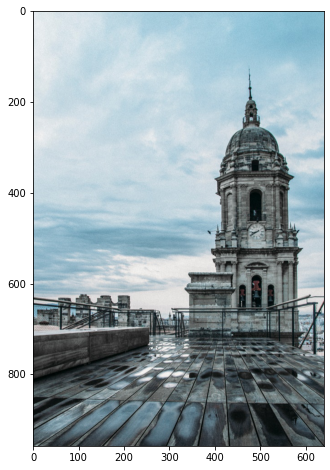

In [9]:
##배경 이미지를 로드한다.(rgb이미지가 로드 된다.)
##넘파이 배열로 바꿔준 후 background 변수에 저장한다.
background = np.array(Image.open('images/background01.jpg'))

##배경 변수의 모양을 높이, 너비로 저장한다.
bg_h, bg_w, _ = background.shape

##전경과 배경을 합치려면 전경의 이미지 크기와 배경의 이미지 크기가 같아야 한다.
##resize로 전경의 가로 크기에 맞게 배경 크기를 재조정한다.
##세로 크기는 달라 질 수 있다.
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

##배경 변수의 모양을 높이, 너비로 저장한다.
bg_h, bg_w, _ = background.shape

##배경의 새로 크기 - 전경의 새로 크기의 차이를 구한다.
margin = (bg_h - fg_h) ## 2

##배경의 새로 크기가 전경의 세로 크기보다 크면,
if margin > 0:

##margin 만큼 세로를 잘라준다.
    background = background[margin:-margin, :, :]

##배경의 새로 크기가 전경의 세로 크기보다 작으면,
else:

##copyMakeBorder : 이미지에 경계선을 만들거나 픽셀을 복사해서 이미지의 크기를 늘린다.
##배경을 top, bottom을 margin 만큼 늘려준다. left와 right는 그대로둔다.
##BORDER_REPLICATE : 픽셀의 끝 부분을 복사해서 top과 bottom 크기 만큼 복사해서 크게 해준다.
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

##전경의 크기와 같도록 사이즈를 재조정한다.
background = cv2.resize(background, dsize=(fg_w, fg_h))

##그래프의 사이즈를 설정한다. (가로:12inch, 세로 28nch)8nch)
plt.figure(figsize=(12, 8))

##배경 이미지를 보여준다.
plt.imshow(background)

# 6. 전경과 배경 분리

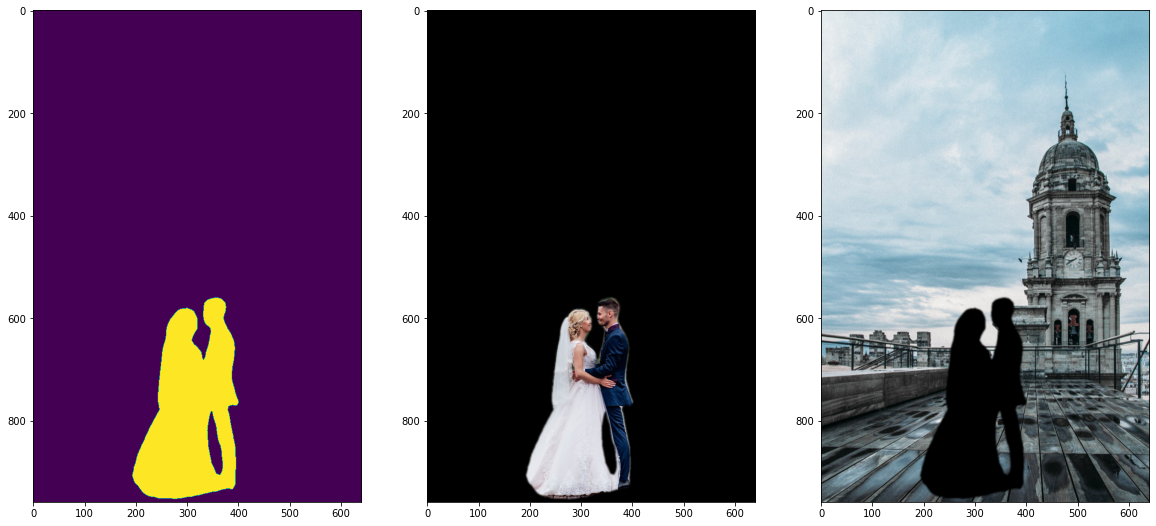

In [10]:
##pred : segmentation 결과에서 argmax까지만 한 결과
##pred가 15인 곳은 다 true로 바뀜 -> float로 바꾸면 true는 1(1.0)이 됨 -> 255를 곱함
##사람이 있는 곳은 255, 배경은 0으로 바뀜
mask = (pred == 15).astype(float) * 255 # 15: person

##threshold : 임계값 처리로 바이너리 마스크를 만든다.
##마스크를 바이너리 형태로 만든다. 0과 255의 값만 갖도록 만든다.
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

##GaussianBlur : 이미지를 흐릿하게 만든다.
##사진 합성 시, 경계를 자연스럽게 만들어 주기 위해 흐릿하게 만든다.
alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

##255로 나누어 0~255 사이의 값을 갖게 만든다.
alpha = alpha / 255. # (height, width)

##alpha가 높이, 너비의 형태를 가지고 있는데, 연산을 하도록 만들려면 이미지랑 같은 형태로 만들어야 하므로, repeat를 사용하여 같은 형태로 만들어 준다.
##3배로 늘어난 이미지 형태의 마스크가 됨
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

##알파 마스크를 이미지와 곱해준다.
##multiply를 사용하면 element-wise로 곱해주는데 이렇게 되면 사람의 이미지만 나온다.
##전경이미지
foreground = cv2.multiply(alpha, img.astype(float))
##사람 부분을 제외한 배경이 나온다.
##배경이미지
background = cv2.multiply(1. - alpha, background.astype(float))  

##3개(1*3)의 axes를 가진 하나의 figure를 생성한다. 사이즈는 20*10이다.
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

##원본이미지를 보여준다.
axes[0].imshow(mask)

##segmemt_map한 전경 이미지를 보여준다.
axes[1].imshow(foreground.astype(np.uint8))

##segmemt_map한 배경이미지를 보여준다.
axes[2].imshow(background.astype(np.uint8))

# 7. 결과

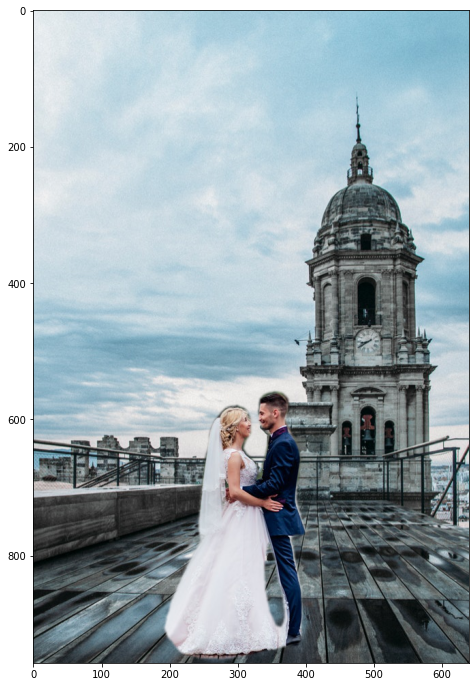

In [11]:
##add를 활용하여 전경이미지와 배경 이미지를 element-wise로 더해준다.
##float형태를 uint8로 바꿔준다.(이미지 형태)
result = cv2.add(foreground, background).astype(np.uint8)

##그래프의 사이즈를 설정한다 (가로:12inch, 세로 12inch)
plt.figure(figsize=(12, 12))

##이미지 결과를 보여준다.
plt.imshow(result)